In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans

from anomaly.constants import GALAXY_LINES

In [2]:
# constants
lines = {
    "NII_1": 6548.041,
    "H-alpha": 6562.787,
    "NII_2": 6583.461,
}

region_name = "halpha_NII"

In [3]:
# directories for data
bin_id = "bin_03"
user = "/home/edgar"
work_directory = f"{user}/spectra/0_01_z_0_5_4_0_snr_inf"
model = "256_128_64/latent_12"
iml_use_case_directory = (
    f"{user}/explain-me-why/sections/" "figures/iml_use_cases"
)

# metric = "mse_filter_250kms_noRel97"
metric = "mse_noRel100"
# metric = "mse_filter_250kms_noRel100"
# metric = "mse_noRel97"
# metric = "mse_filter_250kms_rel100"
# metric = "mse_filter_250kms_rel97"
# metric = "mse_rel100"
# metric = "mse_rel97"
data_directory = f"{work_directory}/{bin_id}/explanation/{model}/{metric}"

In [4]:
wave = np.load(f"{work_directory}/wave_spectra_imputed.npy")
anomalies = np.load(f"{data_directory}/top_anomalies.npy")
df_anomalies = pd.read_csv(
    f"{data_directory}/top_anomalies.csv.gz", index_col="specobjid"
)

# load the weights
explanation_weights = np.load(
    f"{data_directory}/explanation_weights/weights_all_abs_"
    f"smooth_True_drop_0.05_{metric}_bin_03.npy"
)

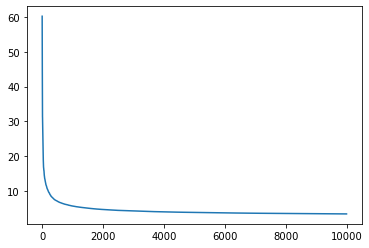

In [5]:
# sort scores in descending order in place in the df
df_anomalies.sort_values(by="score", ascending=False, inplace=True)
# reverse spectra in anomalies array as well
anomalies = anomalies[::-1]
plt.plot(df_anomalies["score"].to_numpy())

In [6]:
explanation_weights.min(), explanation_weights.max()

(0.0, 1.0)

## Clustering of weights for H $\alpha$ + [NII] doublet

In [7]:
# Define the regions of interest
radious = 20

mask_region_of_interest = wave > lines["NII_1"] - radious
mask_region_of_interest &= wave < lines["NII_2"] + radious

75

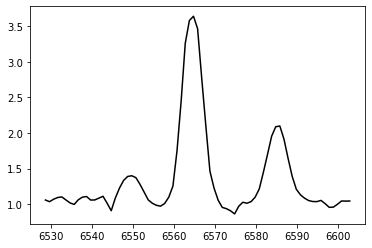

In [8]:
plt.plot(
    wave[mask_region_of_interest],
    anomalies[-10][mask_region_of_interest],
    color="black",
)
mask_region_of_interest.sum()

In [9]:
# create array to store the weights of the h alpha NII region
region_weights = explanation_weights[:, mask_region_of_interest]
anomalies_region_of_interest = anomalies[:, mask_region_of_interest]
wave_region_of_interest = wave[mask_region_of_interest]
region_weights.shape, anomalies_region_of_interest.shape

((10000, 75), (10000, 75))

In [10]:
# # Create a list to store the evaluation metric values
# inertias = []
# n_clusters = range(2, 12)
# # Fit the k-means model with a range of values for the number of clusters
# for n in n_clusters:
#     kmeans = KMeans(n_clusters=n, random_state=0)
#     kmeans.fit(region_weights)
#     inertias.append(kmeans.inertia_)
#     print(f"n: {n}, inertia: {kmeans.inertia_}", end="\r")

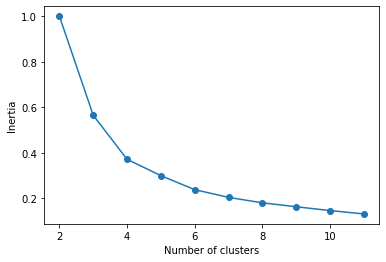

In [11]:
# # Plot the evaluation metric values against the number of clusters
# fig, ax = plt.subplots(figsize=None)

# inertias = np.array(inertias)
# inertias = inertias / inertias.max()
# ax.plot(n_clusters, inertias, '-o')
# ax.set_xlabel('Number of clusters')
# ax.set_ylabel('Inertia')

# save_to = f"{user}/explain-me-why/sections/figures/iml_use_cases"

# fig.savefig(
#     f"{save_to}/kmeans_inertias_region_{region_name}_{metric}.pdf"
# )

In [15]:
# Use k-means clustering to group the spectra
kmeans = KMeans(n_clusters=6, random_state=0)
cluster_labels = kmeans.fit_predict(region_weights)

In [16]:
from typing import Tuple
from matplotlib.figure import Figure
from matplotlib.axes import Axes


def fig_axs_interpret_cluster(
    wave: np.array,
    mean_anomaly: np.array,
    median_anomaly: np.array,
    median_weights: np.array,
    mean_weights: np.array,
    fig_size=None,
) -> Tuple[Figure, Axes]:
    """
    Plot the mean and median anomaly and the mean and median
    explanation weights.

    INPUT

    wave: wavelength array
    mean_anomaly: mean anomaly array
    median_anomaly: median anomaly array
    median_weights: median explanation weights array
    mean_weights: mean explanation weights array
    fig_size: figure size

    OUTPUT

    fig: figure
    axs: axes
    """

    fig, axs = plt.subplots(
        nrows=3,
        ncols=1,
        figsize=fig_size,
        sharex=True,
        sharey=False,
        tight_layout=True,
    )

    axs[0].plot(wave, median_anomaly, c="black", label="Median")
    axs[0].set_ylabel("Normalized flux", fontsize=8)

    axs[1].plot(wave, mean_anomaly, c="black", label="Mean")
    axs[1].set_ylabel("Normalized flux", fontsize=8)

    axs[2].plot(wave, median_weights, color="black", label="Median")
    axs[2].plot(wave, mean_weights, color="blue", label="Mean")

    axs[2].set_ylabel("Explanation weight", fontsize=8)
    axs[2].set_ylim(0, 1.01)

    return fig, axs

Cluster N 0: 1215
Cluster N 1: 2836
Cluster N 2: 1963
Cluster N 3: 962
Cluster N 4: 1169
Cluster N 5: 1855


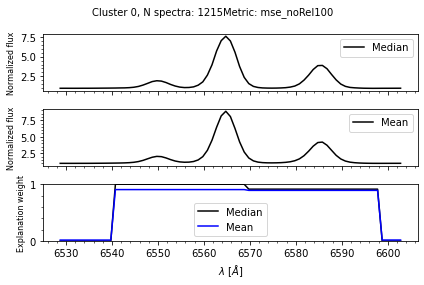

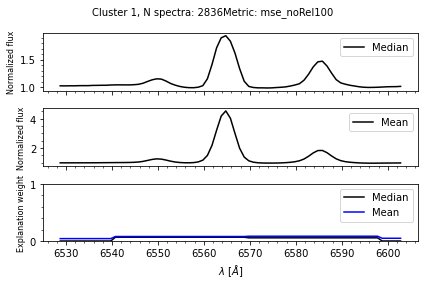

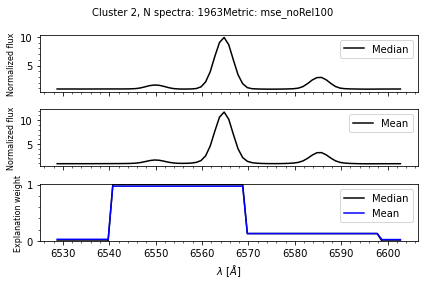

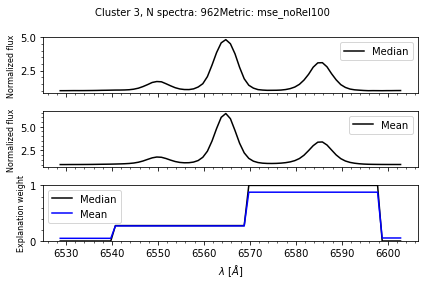

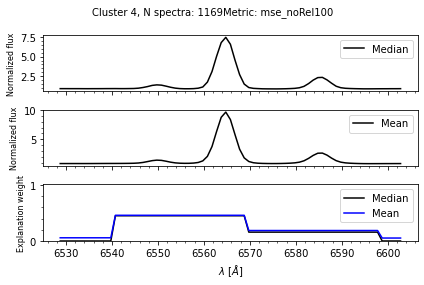

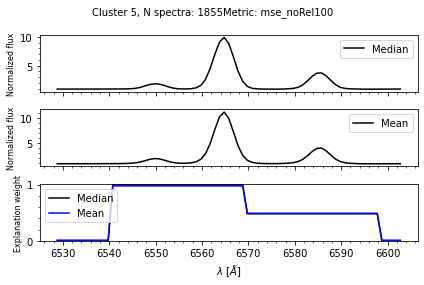

In [17]:
# plot mean and median of the anomalies and explanation weights
# per cluster
n_clusters = kmeans.n_clusters

for cluster_number in range(n_clusters):

    # Select the spectra in the cluster
    cluster_anomalies = anomalies_region_of_interest[
        cluster_labels == cluster_number
    ]

    n_spectra_in_cluster = len(cluster_anomalies)

    cluster_weights = region_weights[cluster_labels == cluster_number]
    cluster_mean_anomaly = np.mean(cluster_anomalies, axis=0)
    cluster_median_anomaly = np.median(cluster_anomalies, axis=0)

    # Compute summary statistics for the explanations in the cluster
    cluster_median_weights = np.median(cluster_weights, axis=0)
    cluster_mean_weights = np.mean(cluster_weights, axis=0)
    cluster_std_weights = np.std(cluster_weights, axis=0)

    fig, axs = fig_axs_interpret_cluster(
        wave=wave_region_of_interest,
        mean_anomaly=cluster_mean_anomaly,
        median_anomaly=cluster_median_anomaly,
        median_weights=cluster_median_weights,
        mean_weights=cluster_mean_weights,
        fig_size=None,
    )

    axs[2].set_xlabel("$\lambda$ [$\AA$]")

    for ax in axs:
        ax.legend()
        ax.minorticks_on()

    fig.suptitle(
        (
            f"Cluster {cluster_number}, "
            f"N spectra: {n_spectra_in_cluster}"
            f"Metric: {metric}"
        ),
        fontsize=10,
    )

    print(f"Cluster N {cluster_number}: " f"{n_spectra_in_cluster}")

    # create cluster directory if it does not exist
    cluster_directory = f"{iml_use_case_directory}/clustering/{region_name}"

    if not os.path.exists(cluster_directory):
        os.makedirs(cluster_directory)

    fig.savefig(
        f"{cluster_directory}/region_{region_name}_"
        f"cluster_{cluster_number}_metric_{metric}_bin_{bin_id}.pdf"
    )